In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy import stats
from numpy import mean
import pickle
import gzip
import time
from ipypb import ipb
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
#plt.rc('font', family='AppleGothic')
#plt.rcParams['axes.unicode_minus'] = False
from matplotlib import gridspec
%matplotlib inline
import pydata_google_auth
from google.cloud import bigquery
credentials = pydata_google_auth.get_user_credentials(
  ['https://www.googleapis.com/auth/bigquery'],
)

project_name= '프로젝트명'
client = bigquery.Client (project = project_name , credentials = credentials) 

pd.options.display.float_format = '{:.5f}'.format

## Part3의 가설 중, "가설3. 남성 outerwear의 판매는 계절의 영향을 받는다." 의 재확인

In [2]:
# Query
s_time = time.time()
query = f"""declare start_date string;
declare end_date string;

##원하는 날짜 입력해주세요
set start_date = '160801';
set end_date = '170731';

## 수정 금지 ##
(생략)
#########

## 기초적으로 활용할 데이터 셋
,
basic_set as (
    select 
  ## 사용자가 어떻게 진입했는지 알려주는 정보
  t1.fullVisitorId
  , t1.visitId
  , concat(t1.fullVisitorId, '_', t1.visitId) as SessionId
  , t1.date as date
  , t1.campaign
  , t1.Source
  , t1.medium
  , t1.keyword
  , t1.channelGrouping as channelGrouping
  ## 기기의 정보
  , t2.browser
  , t2.deviceCategory
  , t2.isMobile
  , t2.operatingSystem
  ## 구매한 제품의 정보 
  , t3.productSKU
  , t3.v2ProductName as v2ProductName
  , t3.v2ProductCategory as v2ProductCategory
  , t3.productVariant
  , t3.productPrice
  , t3.productListName
  , t3.productRefundAmount
  , t3.isImpression as isImpression
from source_information as t1
join device_info as t2 on t1.fullVisitorId = t2.fullVisitorId
join product_data as t3 on t1.fullVisitorId = t3.fullVisitorId
                          and t1.visitId = t3.visitId
)

, season_set as (
select SessionId, date, campaign, Source, medium, channelGrouping, browser, isMobile, v2ProductCategory, v2ProductName, isImpression
,case 
when extract(month from parse_date('%Y%m%d', date)) in (12,1,2) then 'winter'
when extract(month from parse_date('%Y%m%d', date)) in (3,4,5) then 'spring'
when extract(month from parse_date('%Y%m%d', date)) in (6,7,8) then 'summer'
when extract(month from parse_date('%Y%m%d', date)) in (9,10,11) then 'autumn'
else 'not_set'
end as Season
from basic_set
where 1=1
and v2ProductCategory like "%%Men's-Outerwear%%"
)

select Season, parse_date('%Y%m%d', date) as date, count(distinct SessionId) as session_cnt
from season_set
where 1=1
and isImpression = 'e-commerce'
group by Season, parse_date('%Y%m%d', date)
"""

season_df = client.query(query).to_dataframe()
print(time.time()-s_time)

16.325429439544678


In [3]:
season_df.head()

,Season,date,session_cnt
0,autumn,2016-10-07,35
1,spring,2017-05-25,24
2,summer,2017-06-20,13
3,spring,2017-04-07,28
4,winter,2016-12-13,46


In [6]:
group1 = season_df.loc[season_df['Season'] == 'spring','session_cnt']
group2 = season_df.loc[season_df['Season'] == 'summer','session_cnt']
group3 = season_df.loc[season_df['Season'] == 'autumn','session_cnt']
group4 = season_df.loc[season_df['Season'] == 'winter','session_cnt']

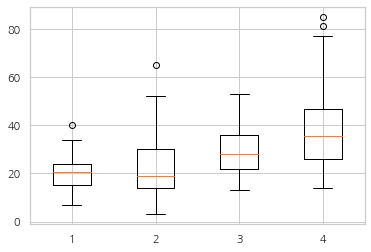

In [7]:
plot_data = [group1, group2, group3, group4]
ax = plt.boxplot(plot_data)
plt.show()

## 제목 누락: plt.title('남성 Outer 계절별 세션 boxplot')

- summer : right skewness

In [8]:
#등분산성 확인 - 레빈 검정
from scipy.stats import levene
print(levene(group1, group2, group3,group4))

#등분산성 확인 - 바틀렛 검정
from scipy.stats import bartlett
print(bartlett(group1, group2, group3,group4))

LeveneResult(statistic=11.906114296577488, pvalue=1.8811416749099253e-07)
BartlettResult(statistic=53.40833513102983, pvalue=1.500329264742767e-11)


- p-value의 결과로 보면, 이분산성으로 확인된다.

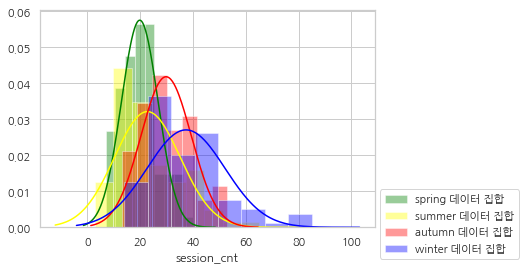

In [19]:
ax = sns.distplot(group1, kde=False, fit=sp.stats.norm, label=f"spring 데이터 집합", color='green')
ax = sns.distplot(group2, kde=False, fit=sp.stats.norm, label=f"summer 데이터 집합", color='yellow')
ax = sns.distplot(group3, kde=False, fit=sp.stats.norm, label=f"autumn 데이터 집합", color='red')
ax = sns.distplot(group4, kde=False, fit=sp.stats.norm, label=f"winter 데이터 집합", color='blue')
ax.lines[0].set_color('green')
ax.lines[1].set_color('yellow')
ax.lines[2].set_color('red')
ax.lines[3].set_color('blue')
plt.title('계절별 Mens outerwear 판매 세션의 등분산성 확인')
plt.legend(bbox_to_anchor=(1.0, .2))
plt.show()

In [21]:
df1 = season_df.loc[season_df['Season'] == 'spring',['Season','session_cnt']]
df2 = season_df.loc[season_df['Season'] == 'summer',['Season','session_cnt']]
df3 = season_df.loc[season_df['Season'] == 'autumn',['Season','session_cnt']]
df4 = season_df.loc[season_df['Season'] == 'winter',['Season','session_cnt']]

In [27]:
result = pd.concat([df1.describe().rename(columns={'session_cnt':'spring'}),
          df2.describe().rename(columns={'session_cnt':'summer'}),
          df3.describe().rename(columns={'session_cnt':'autumn'}),
          df4.describe().rename(columns={'session_cnt':'winter'})],axis=1)

In [30]:
result[result.index.isin(['mean','25%', '50%', '75%'])]

,spring,summer,autumn,winter
mean,19.85870,22.73913,29.83516,37.38889
25%,15.00000,14.00000,22.00000,26.00000
50%,20.50000,19.00000,28.00000,35.50000
75%,24.00000,30.25000,36.00000,46.75000


**CVR로 가설 재검증**

In [67]:
# Query
s_time = time.time()
query = f"""declare start_date string;
declare end_date string;

##원하는 날짜 입력
set start_date = '160801';
set end_date = '170731';

## ##
(코드 생략)
#########


## 기초적으로 활용할 데이터 셋
,
basic_set as (
    select 
  ## 사용자가 어떻게 진입했는지 알려주는 정보
  t1.fullVisitorId
  , t1.visitId
  , concat(t1.fullVisitorId, '_', t1.visitId) as SessionId
  , t1.date as date
  , t1.campaign
  , t1.Source
  , t1.medium
  , t1.keyword
  , t1.channelGrouping as channelGrouping
  ## 기기의 정보
  , t2.browser
  , t2.deviceCategory
  , t2.isMobile
  , t2.operatingSystem
  ## 구매한 제품의 정보 
  , t3.productSKU
  , t3.v2ProductName as v2ProductName
  , t3.v2ProductCategory as v2ProductCategory
  , t3.productVariant
  , t3.productPrice
  , t3.productListName
  , t3.productRefundAmount
  , t3.isImpression as isImpression
from source_information as t1
join device_info as t2 on t1.fullVisitorId = t2.fullVisitorId
join product_data as t3 on t1.fullVisitorId = t3.fullVisitorId
                          and t1.visitId = t3.visitId
)

, season_set as (
select SessionId, date, campaign, Source, medium, channelGrouping, browser, isMobile, v2ProductCategory, v2ProductName, isImpression
,case 
when extract(month from parse_date('%Y%m%d', date)) in (12,1,2) then 'winter'
when extract(month from parse_date('%Y%m%d', date)) in (3,4,5) then 'spring'
when extract(month from parse_date('%Y%m%d', date)) in (6,7,8) then 'summer'
when extract(month from parse_date('%Y%m%d', date)) in (9,10,11) then 'autumn'
else 'not_set'
end as Season
from basic_set
where 1=1
and v2ProductCategory like "%%Men's-Outerwear%%"
)
, buying_set as (
select Season, parse_date('%Y%m%d', date) as date, count(distinct SessionId) as session_cnt
from season_set
where 1=1
and isImpression = 'e-commerce'
group by Season, parse_date('%Y%m%d', date)
)
, total_set as (
select Season, parse_date('%Y%m%d', date) as date, count(distinct SessionId) as total_session_cnt
from season_set
group by Season, parse_date('%Y%m%d', date)
)

select t.Season, t.date, b.session_cnt, t.total_session_cnt from buying_set b right join total_set t 
on (b.Season = t.Season and b.date = t.date)
"""

res_df = client.query(query).to_dataframe()
print(time.time()-s_time)

16.743913412094116


In [8]:
res_df.head()

,Season,date,session_cnt,total_session_cnt
0,autumn,2016-09-09,34,110
1,summer,2017-07-24,23,76
2,winter,2017-01-28,33,152
3,summer,2016-08-06,16,71
4,winter,2017-02-19,24,89


In [68]:
res_df = res_df.assign(cvr = round(res_df['session_cnt'] / res_df['total_session_cnt'],4))

In [69]:
res_df.head()

,Season,date,session_cnt,total_session_cnt,cvr
0,winter,2016-12-05,56,165,0.33940
1,summer,2017-07-31,31,86,0.36050
2,summer,2017-07-09,10,42,0.23810
3,autumn,2016-11-15,27,112,0.24110
4,winter,2017-01-26,47,194,0.24230


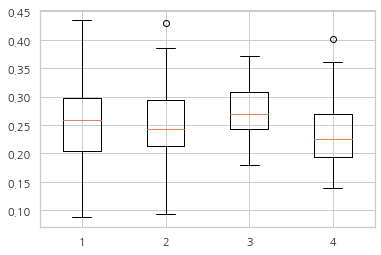

In [21]:
group1 = res_df.loc[res_df['Season'] == 'spring','cvr']
group2 = res_df.loc[res_df['Season'] == 'summer','cvr']
group3 = res_df.loc[res_df['Season'] == 'autumn','cvr']
group4 = res_df.loc[res_df['Season'] == 'winter','cvr']
plot_data = [group1, group2, group3, group4]
ax = plt.boxplot(plot_data)
plt.show()
## 제목 누락: plt.title('남성 Outer 계절별 CVR boxplot')

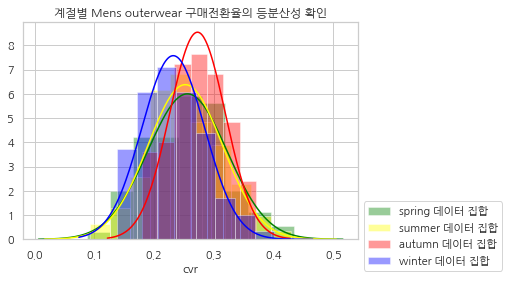

In [22]:
ax = sns.distplot(group1, kde=False, fit=sp.stats.norm, label=f"spring 데이터 집합", color='green')
ax = sns.distplot(group2, kde=False, fit=sp.stats.norm, label=f"summer 데이터 집합", color='yellow')
ax = sns.distplot(group3, kde=False, fit=sp.stats.norm, label=f"autumn 데이터 집합", color='red')
ax = sns.distplot(group4, kde=False, fit=sp.stats.norm, label=f"winter 데이터 집합", color='blue')
ax.lines[0].set_color('green')
ax.lines[1].set_color('yellow')
ax.lines[2].set_color('red')
ax.lines[3].set_color('blue')
plt.title('계절별 Mens outerwear 구매전환율의 등분산성 확인')
plt.legend(bbox_to_anchor=(1.0, .2))
plt.show()

In [23]:
#등분산성 확인 - 레빈 검정
from scipy.stats import levene
print(levene(group1, group2, group3,group4))

#등분산성 확인 - 바틀렛 검정
from scipy.stats import bartlett
print(bartlett(group1, group2, group3,group4))

LeveneResult(statistic=3.8757747106528444, pvalue=0.0094825358944602)
BartlettResult(statistic=13.635376699873728, pvalue=0.0034459200387099986)


In [7]:
#res_df['month'] = res_df['date'].apply(lambda x: x.month)
def q50(x):
    return x.quantile(0.5)
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)
res_df.groupby(['Season']).agg({'cvr':['mean',q25, q50, q75]}).T

In [70]:
res_df.groupby(['Season']).agg({'cvr':['mean',q25, q50, q75],'session_cnt':['mean',q25, q50, q75]}).T

Season             autumn   spring   summer   winter
cvr         mean  0.27259  0.25565  0.25206  0.23199
            q25   0.24250  0.20370  0.21293  0.19382
            q50   0.26850  0.25955  0.24225  0.22455
            q75   0.30840  0.29753  0.29333  0.26895
session_cnt mean 29.83516 19.85870 22.73913 37.38889
            q25  22.00000 15.00000 14.00000 26.00000
            q50  28.00000 20.50000 19.00000 35.50000
            q75  36.00000 24.00000 30.25000 46.75000

- 이 결과로 추정가능한 점은, 판매 세션 수로만 보았을 때에는 계절에 따른 판매 세션 수의 변화의 차이가 보였지만 **구매전환율**로 보았을 때에는 그 차이를 명확히 확인할 수 없다는 것입니다.
- 즉, 봄과 여름보다는 가을,겨울에 유입은 많아지지만 실제 구매의 전환의 비율은 대동소이하다고 볼 수 있습니다. (유입이 커졌으니 그만큼 구매도 많아진 것일 뿐)

**추가로 여성 outer에 관해서도 확인해보았습니다.**

In [33]:
# Query
s_time = time.time()
query = f"""declare start_date string;
declare end_date string;

##원하는 날짜 입력
set start_date = '160801';
set end_date = '170731';

## ##
(생략)
#########


## 기초적으로 활용할 데이터 셋
,
basic_set as (
    select 
  ## 사용자가 어떻게 진입했는지 알려주는 정보
  t1.fullVisitorId
  , t1.visitId
  , concat(t1.fullVisitorId, '_', t1.visitId) as SessionId
  , t1.date as date
  , t1.campaign
  , t1.Source
  , t1.medium
  , t1.keyword
  , t1.channelGrouping as channelGrouping
  ## 기기의 정보
  , t2.browser
  , t2.deviceCategory
  , t2.isMobile
  , t2.operatingSystem
  ## 구매한 제품의 정보 
  , t3.productSKU
  , t3.v2ProductName as v2ProductName
  , t3.v2ProductCategory as v2ProductCategory
  , t3.productVariant
  , t3.productPrice
  , t3.productListName
  , t3.productRefundAmount
  , t3.isImpression as isImpression
from source_information as t1
join device_info as t2 on t1.fullVisitorId = t2.fullVisitorId
join product_data as t3 on t1.fullVisitorId = t3.fullVisitorId
                          and t1.visitId = t3.visitId
)

, season_set as (
select SessionId, date, campaign, Source, medium, channelGrouping, browser, isMobile, v2ProductCategory, v2ProductName, isImpression
,case 
when extract(month from parse_date('%Y%m%d', date)) in (12,1,2) then 'winter'
when extract(month from parse_date('%Y%m%d', date)) in (3,4,5) then 'spring'
when extract(month from parse_date('%Y%m%d', date)) in (6,7,8) then 'summer'
when extract(month from parse_date('%Y%m%d', date)) in (9,10,11) then 'autumn'
else 'not_set'
end as Season
from basic_set
where 1=1
and v2ProductCategory like "%%Women's-Outerwear%%"
)
, buying_set as (
select Season, parse_date('%Y%m%d', date) as date, count(distinct SessionId) as session_cnt
from season_set
where 1=1
and isImpression = 'e-commerce'
group by Season, parse_date('%Y%m%d', date)
)
, total_set as (
select Season, parse_date('%Y%m%d', date) as date, count(distinct SessionId) as total_session_cnt
from season_set
group by Season, parse_date('%Y%m%d', date)
)

select t.Season, t.date, b.session_cnt, t.total_session_cnt from buying_set b right join total_set t 
on (b.Season = t.Season and b.date = t.date)
"""

res_df = client.query(query).to_dataframe()
print(time.time()-s_time)

18.545506238937378


In [34]:
res_df = res_df.assign(cvr = round(res_df['session_cnt'] / res_df['total_session_cnt'],4))

In [66]:
res_df.groupby(['Season']).agg({'cvr':['mean',q25, q50, q75],'session_cnt':['mean',q25, q50, q75]}).T

Season             autumn  spring   summer   winter
cvr         mean  0.27277 0.23722  0.25685  0.26163
            q25   0.20590 0.18438  0.18877  0.18465
            q50   0.26670 0.23170  0.26870  0.24120
            q75   0.32970 0.30000  0.31820  0.32440
session_cnt mean 10.38462 6.72826  9.36957  8.46667
            q25   6.00000 4.00000  4.00000  5.00000
            q50  10.00000 7.00000  7.00000  7.00000
            q75  14.00000 9.00000 13.00000 10.75000

In [37]:
res_df
## 컬럼 설명 ##
# session_cnt = 구매 발생 세션 수
# total_session_cnt = 전체 세션 수

,Season,date,session_cnt,total_session_cnt,cvr
0,autumn,2016-11-21,9.00000,43,0.20930
1,winter,2016-12-01,10.00000,51,0.19610
2,winter,2017-02-17,6.00000,51,0.11760
3,spring,2017-04-16,7.00000,25,0.28000
4,spring,2017-04-24,10.00000,43,0.23260
...,...,...,...,...,...
360,spring,2017-03-31,3.00000,13,0.23080
361,summer,2017-06-13,4.00000,22,0.18180
362,winter,2017-01-26,7.00000,33,0.21210
363,spring,2017-03-25,4.00000,14,0.28570


In [50]:
res_df.fillna(0,inplace=True)

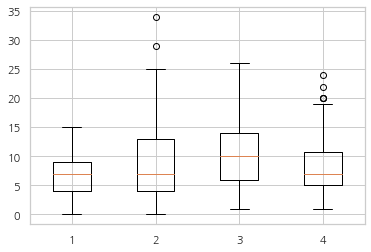

In [65]:
group1 = res_df.loc[res_df['Season'] == 'spring','session_cnt']
group2 = res_df.loc[res_df['Season'] == 'summer','session_cnt']
group3 = res_df.loc[res_df['Season'] == 'autumn','session_cnt']
group4 = res_df.loc[res_df['Season'] == 'winter','session_cnt']
plot_data = [group1, group2, group3, group4]
ax = plt.boxplot(plot_data)
plt.show()

## 제목 누락: plt.title('여성 Outer 계절별 세션 boxplot')

위 boxplot title: "여성 Outer 계절별 세션 boxplot"

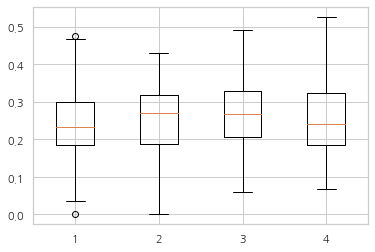

In [51]:
group1 = res_df.loc[res_df['Season'] == 'spring','cvr']
group2 = res_df.loc[res_df['Season'] == 'summer','cvr']
group3 = res_df.loc[res_df['Season'] == 'autumn','cvr']
group4 = res_df.loc[res_df['Season'] == 'winter','cvr']
plot_data = [group1, group2, group3, group4]
ax = plt.boxplot(plot_data)
plt.show()
## 제목 누락: plt.title('여성 Outer 계절별 CVR boxplot')

위 boxplot title: "여성 Outer 계절별 CVR boxplot"

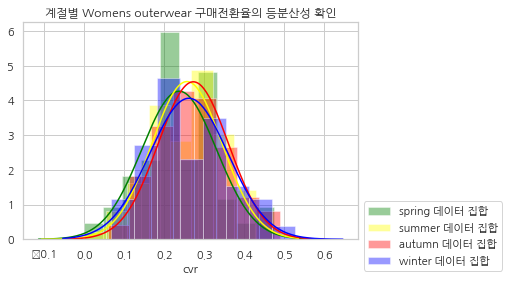

In [52]:
ax = sns.distplot(group1, kde=False, fit=sp.stats.norm, label=f"spring 데이터 집합", color='green')
ax = sns.distplot(group2, kde=False, fit=sp.stats.norm, label=f"summer 데이터 집합", color='yellow')
ax = sns.distplot(group3, kde=False, fit=sp.stats.norm, label=f"autumn 데이터 집합", color='red')
ax = sns.distplot(group4, kde=False, fit=sp.stats.norm, label=f"winter 데이터 집합", color='blue')
ax.lines[0].set_color('green')
ax.lines[1].set_color('yellow')
ax.lines[2].set_color('red')
ax.lines[3].set_color('blue')
plt.title('계절별 Womens outerwear 구매전환율의 등분산성 확인')
plt.legend(bbox_to_anchor=(1.0, .2))
plt.show()

In [53]:
#등분산성 확인 - 레빈 검정
from scipy.stats import levene
print(levene(group1, group2, group3,group4))

#등분산성 확인 - 바틀렛 검정
from scipy.stats import bartlett
print(bartlett(group1, group2, group3,group4))

LeveneResult(statistic=0.645727696159902, pvalue=0.5860751000351259)
BartlettResult(statistic=1.5815888012835366, pvalue=0.6635716031923831)


In [55]:
# statsmodel을 활용한 일원분산분석 실행

# cvr과 Season
model = ols('cvr ~ C(Season)', res_df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(Season),3.00000,0.06055,0.02018,2.36210,0.07103
Residual,361.00000,3.08461,0.00854,NaN,NaN


In [56]:
# session_cnt(세션 수)와 Season
model = ols('session_cnt ~ C(Season)', res_df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(Season),3.00000,661.64215,220.54738,7.89733,0.00004
Residual,361.00000,10081.57977,27.92681,NaN,NaN


In [58]:
# Query
s_time = time.time()
query = f"""declare start_date string;
declare end_date string;

##원하는 날짜 입력
set start_date = '160801';
set end_date = '170731';

####
(생략)
#########


## 기초적으로 활용할 데이터 셋
,
basic_set as (
    select 
  ## 사용자가 어떻게 진입했는지 알려주는 정보
  t1.fullVisitorId
  , t1.visitId
  , concat(t1.fullVisitorId, '_', t1.visitId) as SessionId
  , t1.date as date
  , t1.campaign
  , t1.Source
  , t1.medium
  , t1.keyword
  , t1.channelGrouping as channelGrouping
  ## 기기의 정보
  , t2.browser
  , t2.deviceCategory
  , t2.isMobile
  , t2.operatingSystem
  ## 구매한 제품의 정보 
  , t3.productSKU
  , t3.v2ProductName as v2ProductName
  , t3.v2ProductCategory as v2ProductCategory
  , t3.productVariant
  , t3.productPrice
  , t3.productListName
  , t3.productRefundAmount
  , t3.isImpression as isImpression
from source_information as t1
join device_info as t2 on t1.fullVisitorId = t2.fullVisitorId
join product_data as t3 on t1.fullVisitorId = t3.fullVisitorId
                          and t1.visitId = t3.visitId
)

, sex_set as (
select SessionId, date, campaign, Source, medium, channelGrouping, browser, isMobile, v2ProductCategory, v2ProductName, isImpression
, case when v2ProductCategory like "%%Men's-Outerwear%%" then 'Men-outer' else 'Women-outer' end as cateGroup
from basic_set
where 1=1
and (v2ProductCategory like "%%Men's-Outerwear%%" or v2ProductCategory like "%%Women's-Outerwear%%")
)

select t.date, g.cateGroup, g.session_cnt, t.total_session_cnt from
(select cateGroup, date, count(distinct SessionId) as session_cnt
from sex_set
group by cateGroup, date) g
left join
(select date, count(distinct SessionId) as total_session_cnt
from basic_set
group by date) t
on g.date = t.date

"""

df = client.query(query).to_dataframe()
print(time.time()-s_time)

19.944076538085938


In [60]:
df.sort_values(['date','cateGroup']).head(10)
# session_cnt = 구매 발생 세션 수
# total_session_cnt = 전체 세션 수

,date,cateGroup,session_cnt,total_session_cnt
326,20160801,Men-outer,135,972
491,20160801,Women-outer,49,972
171,20160802,Men-outer,141,1091
494,20160802,Women-outer,62,1091
587,20160803,Men-outer,157,1296
613,20160803,Women-outer,58,1296
379,20160804,Men-outer,155,1459
447,20160804,Women-outer,64,1459
664,20160805,Men-outer,136,1223
177,20160805,Women-outer,75,1223


Text(0.5, 1.0, "Traffic Trend of Men's & Women's Outer (2016.08 ~ 2017.07)")

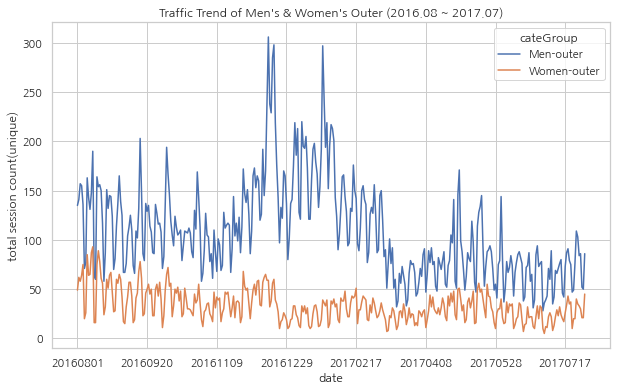

In [83]:
ax = pd.pivot_table(values='session_cnt',columns='cateGroup',index='date',aggfunc='sum',data=df).plot(figsize=(10,6))
ax.set_ylabel('total session count(unique)')
ax.set_title("Traffic Trend of Men's & Women's Outer (2016.08 ~ 2017.07)")

- 유입이 압도적으로 많은(Women의 약 3~4배) Men을 중점으로 프로모션을 진행할 계획입니다.

In [71]:
# Query
s_time = time.time()
query = f"""declare start_date string;
declare end_date string;

##원하는 날짜 입력해주세요
set start_date = '160801';
set end_date = '170731';

## 수정 금지 ##
(생략)
#########


## 기초적으로 활용할 데이터 셋
,
basic_set as (
    select 
  ## 사용자가 어떻게 진입했는지 알려주는 정보
  t1.fullVisitorId
  , t1.visitId
  , concat(t1.fullVisitorId, '_', t1.visitId) as SessionId
  , t1.date as date
  , t1.campaign
  , t1.Source
  , t1.medium
  , t1.keyword
  , t1.channelGrouping as channelGrouping
  ## 기기의 정보
  , t2.browser
  , t2.deviceCategory
  , t2.isMobile
  , t2.operatingSystem
  ## 구매한 제품의 정보 
  , t3.productSKU
  , t3.v2ProductName as v2ProductName
  , t3.v2ProductCategory as v2ProductCategory
  , t3.productVariant
  , t3.productPrice
  , t3.productListName
  , t3.productRefundAmount
  , t3.isImpression as isImpression
from source_information as t1
join device_info as t2 on t1.fullVisitorId = t2.fullVisitorId
join product_data as t3 on t1.fullVisitorId = t3.fullVisitorId
                          and t1.visitId = t3.visitId
)

, season_set as (
select SessionId, date, campaign, Source, medium, channelGrouping, browser, isMobile, v2ProductCategory, v2ProductName, isImpression
,case 
when extract(month from parse_date('%Y%m%d', date)) in (12,1,2) then 'winter'
when extract(month from parse_date('%Y%m%d', date)) in (3,4,5) then 'spring'
when extract(month from parse_date('%Y%m%d', date)) in (6,7,8) then 'summer'
when extract(month from parse_date('%Y%m%d', date)) in (9,10,11) then 'autumn'
else 'not_set'
end as Season
from basic_set
where 1=1
and v2ProductCategory like "%%Men's-Outerwear%%"
)
, buying_set as (
select Season, count(distinct SessionId) as session_cnt
from season_set
where 1=1
and isImpression = 'e-commerce'
group by Season
)
, total_set as (
select Season, count(distinct SessionId) as total_session_cnt
from season_set
group by Season
)

select t.Season, b.session_cnt, t.total_session_cnt,
IEEE_DIVIDE(b.session_cnt, t.total_session_cnt) as cvr
from buying_set b right join total_set t 
on b.Season = t.Season
"""

season_summary = client.query(query).to_dataframe()
print(time.time()-s_time)

17.788092136383057


In [77]:
from pandas.api.types import CategoricalDtype
cat_size_order = CategoricalDtype(
    ['spring', 'summer', 'autumn', 'winter'], 
    ordered=True
)
season_summary['Season'] = season_summary['Season'].astype(cat_size_order)

season_summary.sort_values('Season')

,Season,session_cnt,total_session_cnt,cvr
0,spring,1818,7387,0.24611
3,summer,2083,8052,0.25869
2,autumn,2705,9890,0.27351
1,winter,3354,14426,0.23250


In [79]:
season_summary['cateGroup'] = "Men's-Outerwear"

display(season_summary.sort_values('Season'))

,Season,session_cnt,total_session_cnt,cvr,cateGroup
0,spring,1818,7387,0.24611,Men's-Outerwear
3,summer,2083,8052,0.25869,Men's-Outerwear
2,autumn,2705,9890,0.27351,Men's-Outerwear
1,winter,3354,14426,0.23250,Men's-Outerwear


- 1년치를 Season별로 묶어서 보아도 CVR에 유의미하다고 할 차이가 없음이 재확인됩니다.

**이어서 타겟 고객이 주로 이용하는 device유형을 확인해봅니다.**

In [39]:
# Query
s_time = time.time()
query = f"""declare start_date string;
declare end_date string;

##원하는 날짜 입력
set start_date = '160801';
set end_date = '170731';

## ##
(생략)
#########


## 기초적으로 활용할 데이터 셋
,
basic_set as (
    select 
  ## 사용자가 어떻게 진입했는지 알려주는 정보
  t1.fullVisitorId
  , t1.visitId
  , concat(t1.fullVisitorId, '_', t1.visitId) as SessionId
  , t1.date as date
  , t1.campaign
  , t1.Source
  , t1.medium
  , t1.keyword
  , t1.channelGrouping as channelGrouping
  ## 기기의 정보
  , t2.browser
  , t2.deviceCategory
  , t2.isMobile
  , t2.operatingSystem
  ## 구매한 제품의 정보 
  , t3.productSKU
  , t3.v2ProductName as v2ProductName
  , t3.v2ProductCategory as v2ProductCategory
  , t3.productVariant
  , t3.productPrice
  , t3.productListName
  , t3.productRefundAmount
  , t3.isImpression as isImpression
from source_information as t1
join device_info as t2 on t1.fullVisitorId = t2.fullVisitorId
join product_data as t3 on t1.fullVisitorId = t3.fullVisitorId
                          and t1.visitId = t3.visitId
)


select t.deviceCategory, t.date, t.total_session_cnt, p.session_cnt
from (
select deviceCategory, extract(month from parse_date('%Y%m%d', date)) as month, count(distinct SessionId) as total_session_cnt
from basic_set
where 1=1
and v2ProductCategory like "%%Men's-Outerwear%%"
group by deviceCategory, extract(month from parse_date('%Y%m%d', date))) t
left join (
select deviceCategory, date, count(distinct SessionId) as session_cnt
from basic_set
where 1=1
and v2ProductCategory like "%%Men's-Outerwear%%"
and isImpression = 'e-commerce'
group by deviceCategory, date) p
on (t.deviceCategory = p.deviceCategory and t.date = p.date)
"""

device_df = client.query(query).to_dataframe()
print(time.time()-s_time)

13.428373098373413


In [37]:
device_df.groupby(['deviceCategory']).agg({'session_cnt':['mean',q25, q50, q75],'total_session_cnt':['mean',q25, q50, q75]}).T

deviceCategory           desktop   mobile  tablet
session_cnt       mean  23.19726  4.01488 1.44094
                  q25   14.00000  2.00000 1.00000
                  q50   21.00000  3.00000 1.00000
                  q75   31.00000  5.00000 2.00000
total_session_cnt mean  86.34795 20.42740 3.27574
                  q25   61.00000 10.00000 1.00000
                  q50   77.00000 15.00000 2.00000
                  q75  113.00000 24.00000 4.00000

- 라이브 커머스 기획을 생각하였으나 Men's outer유입은 desktop이 Mobile의 4배가량 더 규모가 큽니다. -> 라이브 커머스는 모바일에 좀 더 적합한 용도라서, 데스크탑용 기획이 필요
- 웹사이트 내 규매유도 방법 고려

In [60]:
# Query
s_time = time.time()
query = f"""declare start_date string;
declare end_date string;

##원하는 날짜 입력
set start_date = '160801';
set end_date = '170731';

## ##
(생략)
#########


## 기초적으로 활용할 데이터 셋
,
basic_set as (
    select 
  ## 사용자가 어떻게 진입했는지 알려주는 정보
  t1.fullVisitorId
  , t1.visitId
  , concat(t1.fullVisitorId, '_', t1.visitId) as SessionId
  , t1.date as date
  , t1.campaign
  , t1.Source
  , t1.medium
  , t1.keyword
  , t1.channelGrouping as channelGrouping
  ## 기기의 정보
  , t2.browser
  , t2.deviceCategory
  , t2.isMobile
  , t2.operatingSystem
  ## 구매한 제품의 정보 
  , t3.productSKU
  , t3.v2ProductName as v2ProductName
  , t3.v2ProductCategory as v2ProductCategory
  , t3.productVariant
  , t3.productPrice
  , t3.productListName
  , t3.productRefundAmount
  , t3.isImpression as isImpression
from source_information as t1
join device_info as t2 on t1.fullVisitorId = t2.fullVisitorId
join product_data as t3 on t1.fullVisitorId = t3.fullVisitorId
                          and t1.visitId = t3.visitId
)


select t.channelGrouping, t.date, t.total_session_cnt, p.session_cnt
from (
select channelGrouping, date, count(distinct SessionId) as total_session_cnt
from basic_set
where 1=1
and v2ProductCategory like "%%Men's-Outerwear%%"
and deviceCategory = 'desktop'
group by channelGrouping, date) t
left join (
select channelGrouping, date, count(distinct SessionId) as session_cnt
from basic_set
where 1=1
and v2ProductCategory like "%%Men's-Outerwear%%"
and deviceCategory = 'desktop'
and isImpression='e-commerce'
group by channelGrouping, date) p
on (t.channelGrouping = p.channelGrouping and t.date = p.date)
"""

source_df = client.query(query).to_dataframe()
print(time.time()-s_time)

18.539734840393066


In [61]:
source_df.head()

,channelGrouping,date,total_session_cnt,session_cnt
0,Display,20161018,2,NaN
1,Referral,20160818,58,20.00000
2,Referral,20161109,15,8.00000
3,Organic Search,20160918,42,14.00000
4,Organic Search,20160906,42,9.00000


In [62]:
source_df['session_cnt'].fillna(0,inplace=True)

In [63]:
source_df = source_df.assign(cvr = round(source_df['session_cnt']/source_df['total_session_cnt'],4))

In [64]:
source_df.isna().sum()

channelGrouping      0
date                 0
total_session_cnt    0
session_cnt          0
cvr                  0
dtype: int64

In [65]:
source_df.groupby(['channelGrouping'])\
.agg({'session_cnt':['mean',q25, q50, q75],'total_session_cnt':['mean',q25, q50, q75],'cvr':['mean',q25, q50, q75]}).T

channelGrouping         (Other)  Affiliates   Direct  Display  Organic Search  \
session_cnt       mean  0.25000     0.33690  2.97778  0.63776         9.84384   
                  q25   0.00000     0.00000  1.00000  0.00000         6.00000   
                  q50   0.00000     0.00000  2.00000  1.00000         9.00000   
                  q75   0.25000     1.00000  4.00000  1.00000        13.00000   
total_session_cnt mean  1.50000     2.02139 11.84722  1.97959        40.98356   
                  q25   1.00000     1.00000  5.00000  1.00000        30.00000   
                  q50   1.00000     1.00000 10.00000  2.00000        40.00000   
                  q75   1.50000     2.00000 16.00000  3.00000        49.00000   
cvr               mean  0.25000     0.17125  0.26113  0.31957         0.23941   
                  q25   0.00000     0.00000  0.14095  0.00000         0.19300   
                  q50   0.00000     0.00000  0.25000  0.22500         0.23330   
                  q75   0.25000     0.22500  0.36360  0.50000         0.29170   

channelGrouping         Paid Search  Referral  Social  
session_cnt       mean      1.03529   8.62192 0.41912  
                  q25       0.00000   4.00000 0.00000  
                  q50       1.00000   7.00000 0.00000  
                  q75       2.00000  12.00000 1.00000  
total_session_cnt mean      3.48529  26.10959 2.96324  
                  q25       2.00000  14.00000 1.00000  
                  q50       3.00000  23.00000 2.00000  
                  q75       5.00000  35.00000 4.00000  
cvr               mean      0.30421   0.33381 0.12482  
                  q25       0.00000   0.26790 0.00000  
                  q50       0.25000   0.33330 0.00000  
                  q75       0.50000   0.40000 0.20000

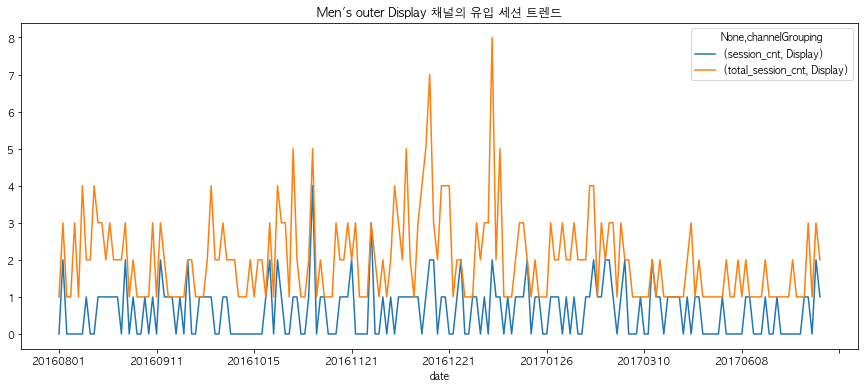

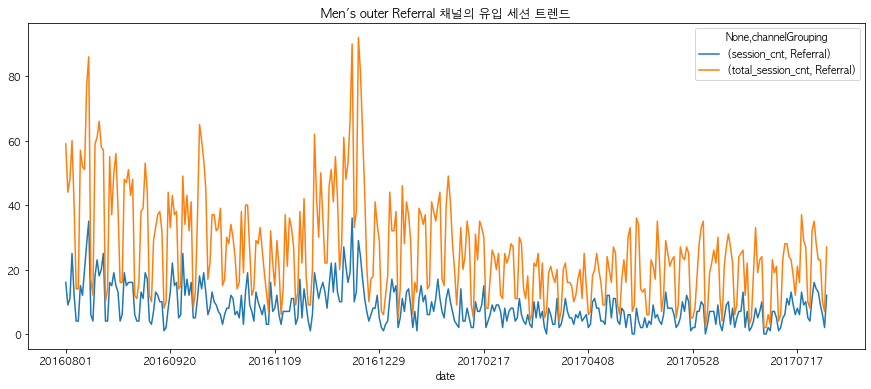

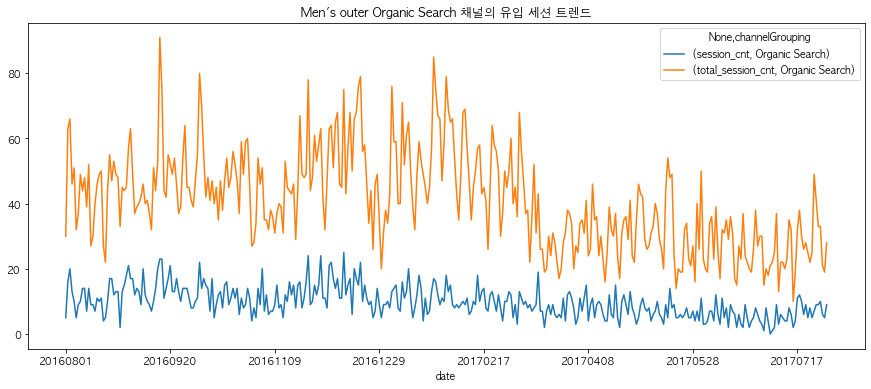

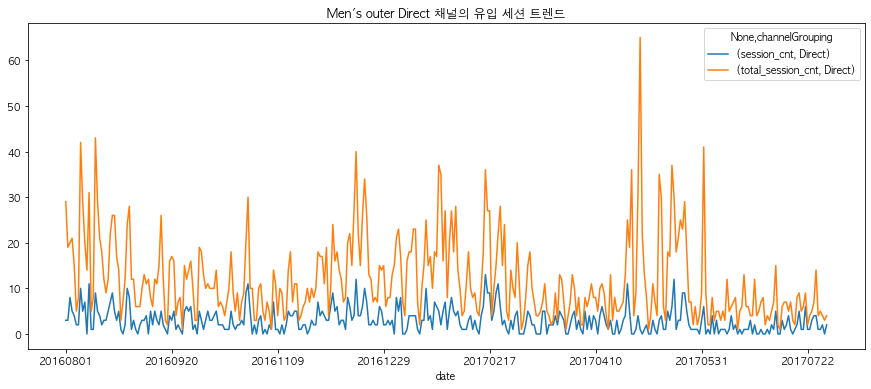

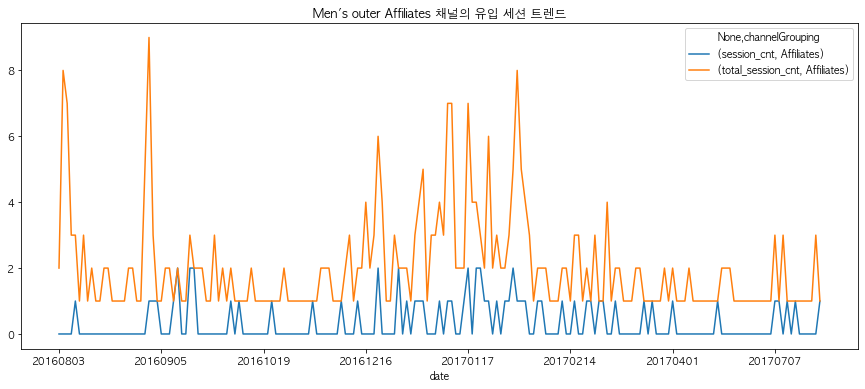

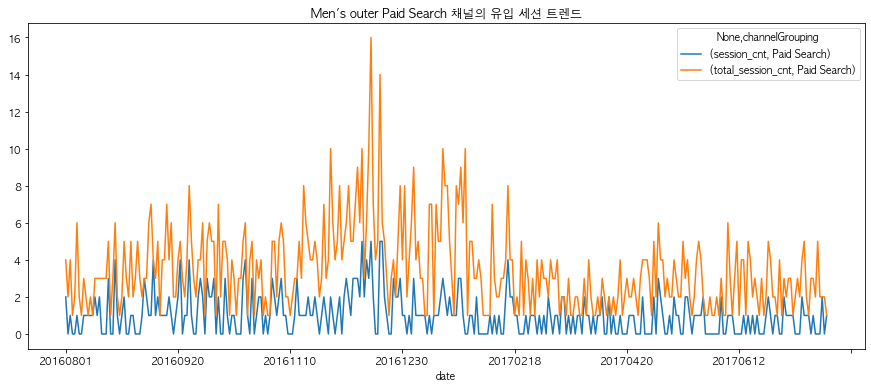

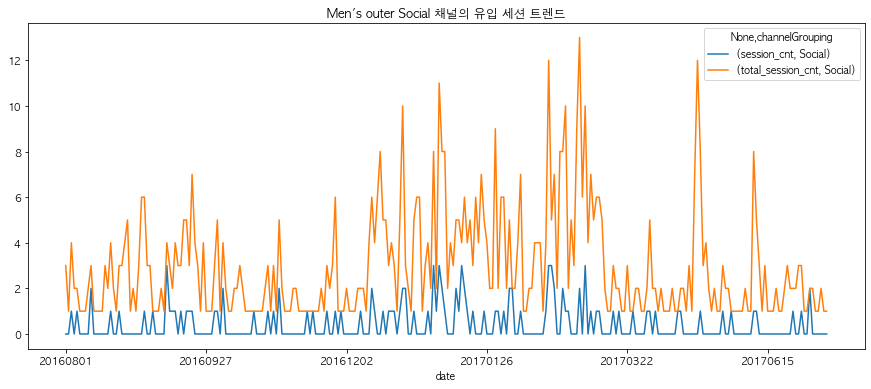

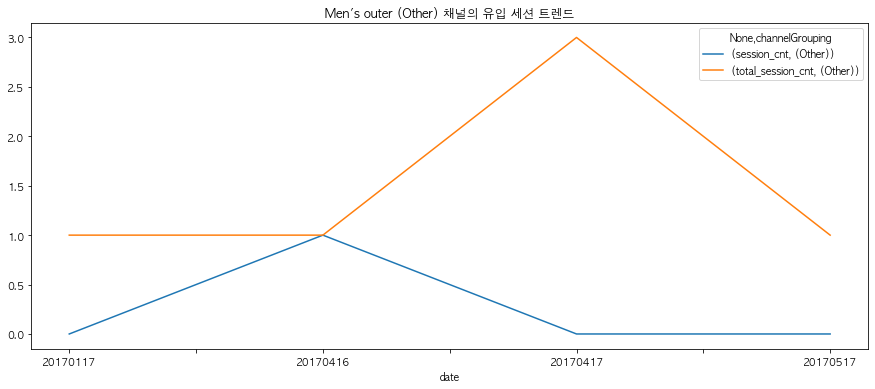

In [70]:
for channel in source_df['channelGrouping'].unique():
    source_df[source_df['channelGrouping'] == channel].pivot_table(values=['session_cnt','total_session_cnt'], columns='channelGrouping',
                     index='date',aggfunc='sum').plot(figsize=(15,6))
    plt.title(f"Men's outer {channel} 채널의 유입 세션 트렌드")
    plt.show()

- Direct 와 Organic Search로의 유입이 대다수
- 코디제안 룩북 상단 배너에 배치 -> 룩북 페이지 클릭 유도 -> 상품상세 조회 클릭으로 유도
- 겨울 준비 기획전, 겨울에도 예쁘게 입자! 등등의 문구로 남성 고객을 구매 유도
- 패션에 신경쓰는 요즘 남성들에게 적절한 코디 제안으로 상품의 구매 의욕을 불러일으키고, 코디로 제안된 상품의 추가 구매까지 유도할 수 있음

    [참고글:빅인](https://brunch.co.kr/@biginsight/28)

In [72]:
client.close()